<a href="https://colab.research.google.com/github/casllmproject/wjs_llm_project/blob/main/german_new_DE_human_ai_alignments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prompt: mount goolge drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import wasserstein_distance
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load human responses
human_df = pd.read_csv('/content/drive/MyDrive/AI_shoes/wjs_de.csv')

# Replace 777 and 999 with NaN
human_df.replace({777: pd.NA, 999: pd.NA}, inplace=True)

# Save the updated dataset
human_df.to_csv('/content/drive/MyDrive/AI_shoes/wjs_de_cleaned.csv', index=False)

print("Replaced 777 and 999 with NA and saved the cleaned dataset.")


Replaced 777 and 999 with NA and saved the cleaned dataset.


In [ ]:
# Load the cleaned human responses
human_df = pd.read_csv('/content/drive/MyDrive/AI_shoes/wjs_de_cleaned.csv')

In [ ]:
# Assuming 'column_name' is the column causing the issue
human_df['pol_view'] = pd.to_numeric(human_df['pol_view'], errors='coerce')
human_df['gender'] = pd.to_numeric(human_df['gender'], errors='coerce')
human_df['mbackg'] = pd.to_numeric(human_df['mbackg'], errors='coerce')
human_df['gen_edu'] = pd.to_numeric(human_df['gen_edu'], errors='coerce')

In [ ]:
# Function to compute distribution of human responses by group
def compute_distribution(df, variable_name, group):
    distribution = df.groupby(group)[variable_name].value_counts(normalize=True).unstack().fillna(0)
    return distribution

# Create political ideological groups
def categorize_political_view(df):
    conditions = [
        (df['pol_view'] <= 4),
        (df['pol_view'] == 5),
        (df['pol_view'] >= 6)
    ]
    choices = ['left', 'center', 'right']
    df['pol_view_group'] = np.select(conditions, choices, default=pd.NA)
    return df

# Apply the categorization
human_df = categorize_political_view(human_df)

# Label mappings
gender_labels = {1: 'Female', 2: 'Male', 3: 'Other'}
empl_labels = {
    1: 'Full-time permanent contract', 2: 'Part-time permanent contract',
    3: 'Full-time fixed-term contract', 4: 'Part-time fixed-term contract',
    5: 'Freelance or self-employed', 6: 'Other'
}
mbackg_labels = {
    1: 'Newspaper', 2: 'Magazine', 3: 'TV', 4: 'Radio', 5: 'News agency',
    6: 'Internet native', 7: 'Telecommunications', 8: 'Other', 9: 'No main medium'
}
gen_edu_labels = {
    1: 'Not completed high school', 2: 'Completed high school',
    3: 'Bachelor’s degree or equivalent', 4: 'Master\'s degree or equivalent',
    5: 'Doctorate', 6: 'Undertook some university studies, but no degree'
}

# Function to map labels
def map_labels(distribution, labels):
    return distribution.rename(index=labels)

# Function to calculate and print distribution for different grouping variables
def compute_and_print_distributions(df, variable_name):
    # Political view group distribution
    political_distribution = compute_distribution(df, variable_name, 'pol_view_group')
    print(f"Distribution by political view group on {variable_name}:")
    print(political_distribution)

    # Gender distribution
    gender_distribution = compute_distribution(df, variable_name, 'gender')
    gender_distribution = map_labels(gender_distribution, gender_labels)
    print(f"\nDistribution by gender on {variable_name}:")
    print(gender_distribution)

    # Employment status distribution
    employment_distribution = compute_distribution(df, variable_name, 'empl')
    employment_distribution = map_labels(employment_distribution, empl_labels)
    print(f"\nDistribution by employment status on {variable_name}:")
    print(employment_distribution)

    # Media background distribution
    media_background_distribution = compute_distribution(df, variable_name, 'mbackg')
    media_background_distribution = map_labels(media_background_distribution, mbackg_labels)
    print(f"\nDistribution by media background on {variable_name}:")
    print(media_background_distribution)

    # General education distribution
    education_distribution = compute_distribution(df, variable_name, 'gen_edu')
    education_distribution = map_labels(education_distribution, gen_edu_labels)
    print(f"\nDistribution by general education on {variable_name}:")
    print(education_distribution)

# Example: Calculate and print distributions for 'role_A'
compute_and_print_distributions(human_df, 'role_A')

Distribution by political view group on role_A:
role_A               1.0       2.0       3.0       4.0       5.0
pol_view_group                                                  
center          0.018634  0.031056  0.146998  0.455487  0.347826
left            0.015707  0.040140  0.136126  0.347295  0.460733
right           0.028986  0.021739  0.094203  0.333333  0.521739

Distribution by gender on role_A:
role_A       1.0       2.0       3.0       4.0       5.0
gender                                                  
Female  0.011673  0.040856  0.173152  0.381323  0.392996
Male    0.021505  0.029186  0.109063  0.390169  0.450077
Other   0.000000  0.000000  0.000000  1.000000  0.000000

Distribution by employment status on role_A:
role_A                              1.0       2.0       3.0       4.0  \
empl                                                                    
Full-time permanent contract   0.016927  0.026042  0.126302  0.391927   
Part-time permanent contract   0.015152  0

In [ ]:
# Function to compute Wasserstein distance between GPT response and human distribution
def compute_wasserstein_distance(human_distribution, gpt_response):
    distances = {}
    for group in human_distribution.index:  # Loop through groups like 'left', 'Female', etc.
        options = human_distribution.columns.astype(int)
        human_probs = human_distribution.loc[group].values
        gpt_value = int(gpt_response)

        # Convert gpt_value to a list and ensure it is in the same range as options
        gpt_probs = np.zeros_like(human_probs)
        if gpt_value in options:
            gpt_probs[options.get_loc(gpt_value)] = 1

        # Compute Wasserstein distance
        distance = wasserstein_distance(gpt_probs, human_probs)
        distances[group] = distance
    return distances

# Example: Compute Wasserstein distance for GPT-4o's response for 'role_A'
gpt_model = 'gpt-4o-2024-08-06'
gpt_responses_df = pd.read_csv(f'/content/drive/MyDrive/AI_shoes/german_gpt-4o-2024-08-06_responses_2nd.csv')

# Find the response for 'role_A' in the GPT responses CSV
gpt_response = gpt_responses_df.loc[gpt_responses_df['Variable_Name'] == 'role_A', 'Response'].values[0]

# Function to compute and display Wasserstein distances for each group
def compute_and_display_distances(df, variable_name, gpt_response, group_col, group_labels, group_name):
    human_distribution = compute_distribution(df, variable_name, group_col)
    distances = compute_wasserstein_distance(human_distribution, gpt_response)

    print(f'\nWasserstein Distances between {gpt_model} and {group_name} distributions for "{variable_name}":')
    for group, distance in distances.items():
        label = group_labels.get(group, group)
        print(f"{label}: {distance}")

# Apply categorization for political view groups
human_df = categorize_political_view(human_df)

# Define labels for each grouping variable
pol_view_labels = {'left': 'Left', 'center': 'Center', 'right': 'Right'}
gender_labels = {1: 'Female', 2: 'Male', 3: 'Other'}
empl_labels = {
    1: 'Full-time permanent contract',
    2: 'Part-time permanent contract',
    3: 'Full-time fixed-term contract',
    4: 'Part-time fixed-term contract',
    5: 'Freelance or self-employed'
}
mbackg_labels = {
    1: 'Newspaper', 2: 'Magazine', 3: 'TV', 4: 'Radio',
    5: 'News agency', 6: 'Internet native', 7: 'Telecommunications',
    8: 'Other', 9: 'No main medium'
}
gen_edu_labels = {
    1: 'Not completed high school',
    2: 'Completed high school',
    3: 'Bachelor’s degree or equivalent',
    4: 'Master\'s degree or equivalent',
    5: 'Doctorate',
    6: 'Undertook some university studies, but no degree'
}

# Calculate and display Wasserstein distances for each grouping variable
compute_and_display_distances(human_df, 'role_A', gpt_response, 'pol_view_group', pol_view_labels, 'political view')
compute_and_display_distances(human_df, 'role_A', gpt_response, 'gender', gender_labels, 'gender')
compute_and_display_distances(human_df, 'role_A', gpt_response, 'empl', empl_labels, 'employment status')
compute_and_display_distances(human_df, 'role_A', gpt_response, 'mbackg', mbackg_labels, 'media background')
compute_and_display_distances(human_df, 'role_A', gpt_response, 'gen_edu', gen_edu_labels, 'general education')



Wasserstein Distances between gpt-4o-2024-08-06 and political view distributions for "role_A":
Center: 0.2178053830227743
Left: 0.21570680628272249
Right: 0.19130434782608693

Wasserstein Distances between gpt-4o-2024-08-06 and gender distributions for "role_A":
Female: 0.24280155642023346
Male: 0.21996927803379418
Other: 0.0

Wasserstein Distances between gpt-4o-2024-08-06 and employment status distributions for "role_A":
Full-time permanent contract: 0.22447916666666667
Part-time permanent contract: 0.19393939393939397
Full-time fixed-term contract: 0.2333333333333333
Part-time fixed-term contract: 0.2095238095238095
Freelance or self-employed: 0.23765690376569037
6.0: 0.13333333333333336

Wasserstein Distances between gpt-4o-2024-08-06 and media background distributions for "role_A":
Newspaper: 0.21524249422632796
Magazine: 0.21399176954732507
TV: 0.19317073170731708
Radio: 0.2019607843137255
News agency: 0.17142857142857143
Internet native: 0.2333333333333333
Telecommunications: 0

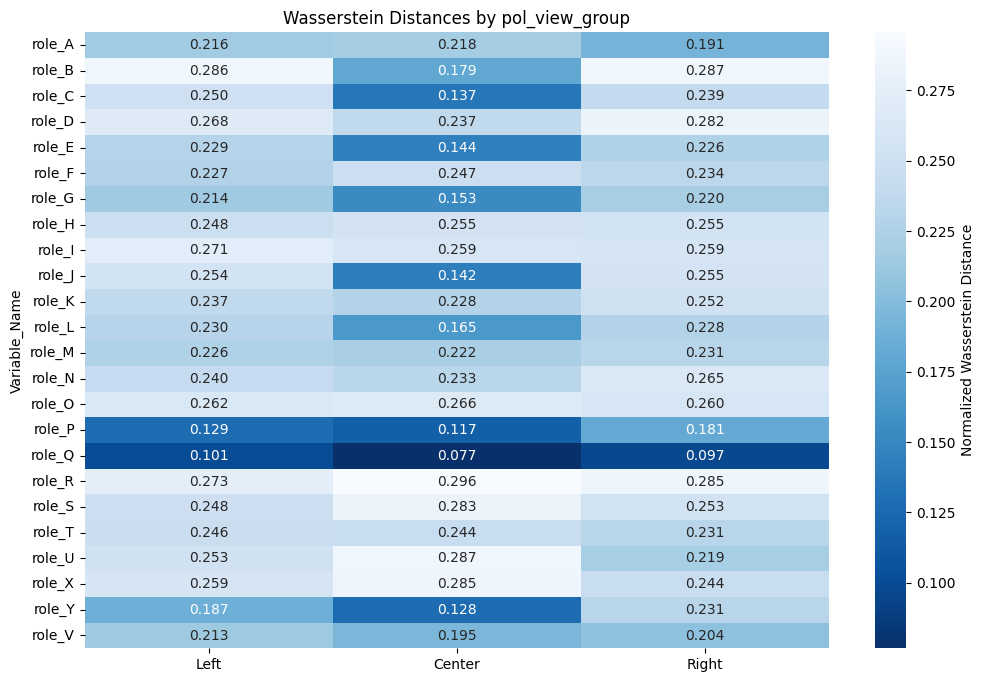

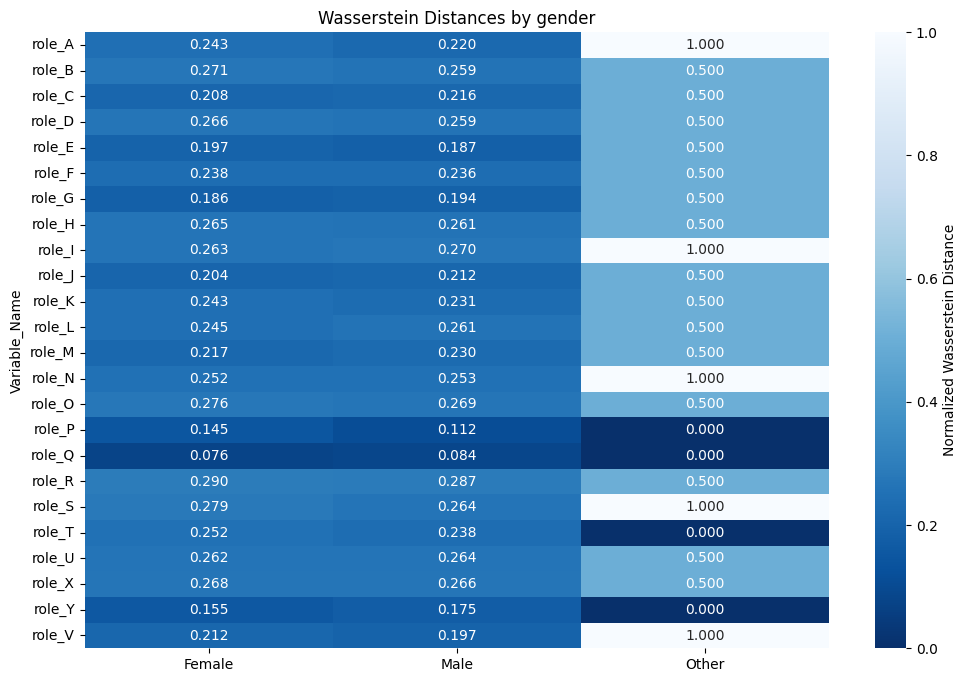

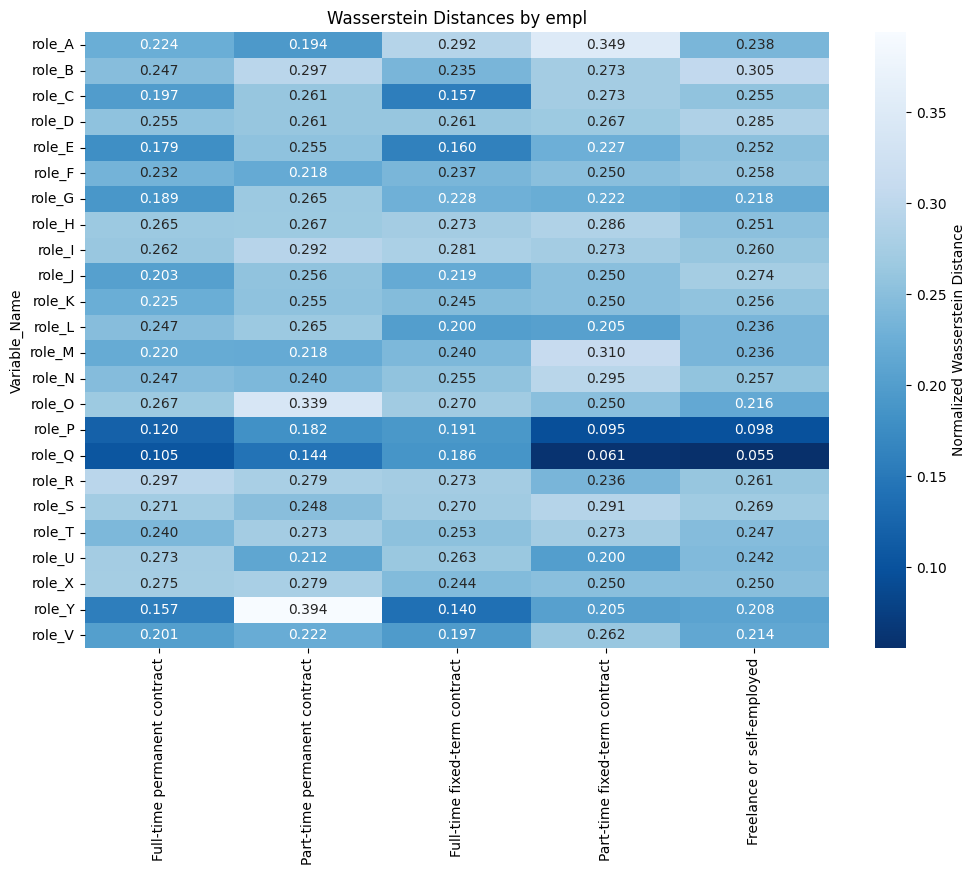

No data for group: Other and variable: role_A
No data for group: Other and variable: role_B
No data for group: Other and variable: role_C
No data for group: Other and variable: role_D
No data for group: Other and variable: role_E
No data for group: Other and variable: role_F
No data for group: Other and variable: role_G
No data for group: Other and variable: role_H
No data for group: Other and variable: role_I
No data for group: Other and variable: role_J
No data for group: Other and variable: role_K
No data for group: Other and variable: role_L
No data for group: Other and variable: role_M
No data for group: Other and variable: role_N
No data for group: Other and variable: role_O
No data for group: Other and variable: role_P
No data for group: Other and variable: role_Q
No data for group: Other and variable: role_R
No data for group: Other and variable: role_S
No data for group: Other and variable: role_T
No data for group: Other and variable: role_U
No data for group: Other and varia

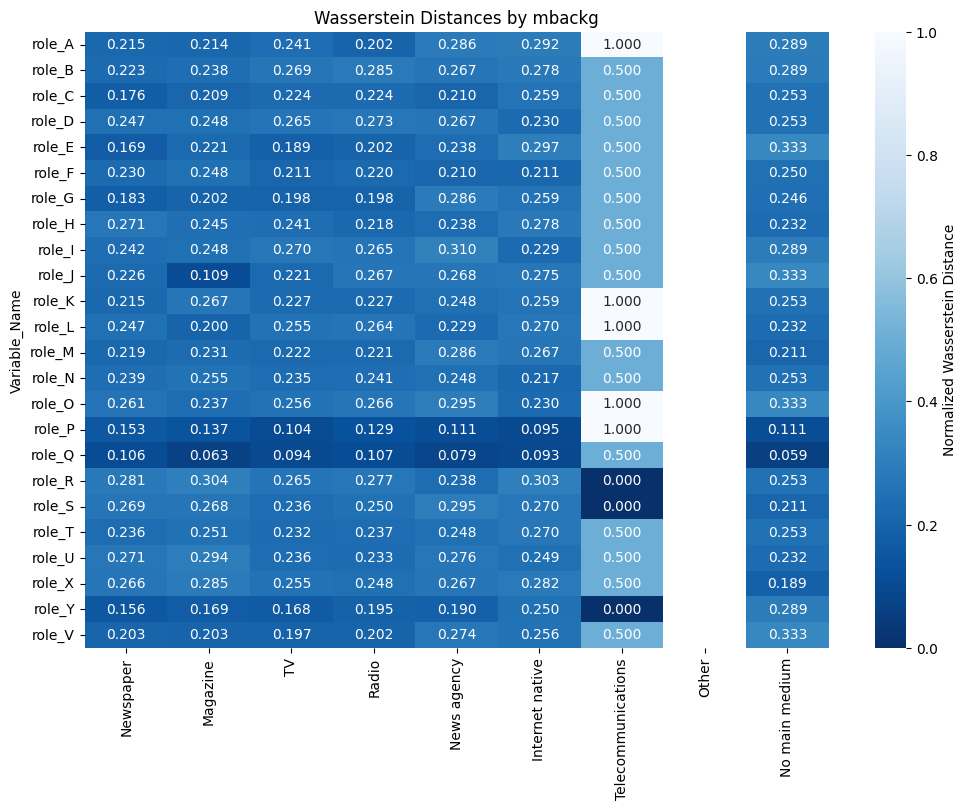

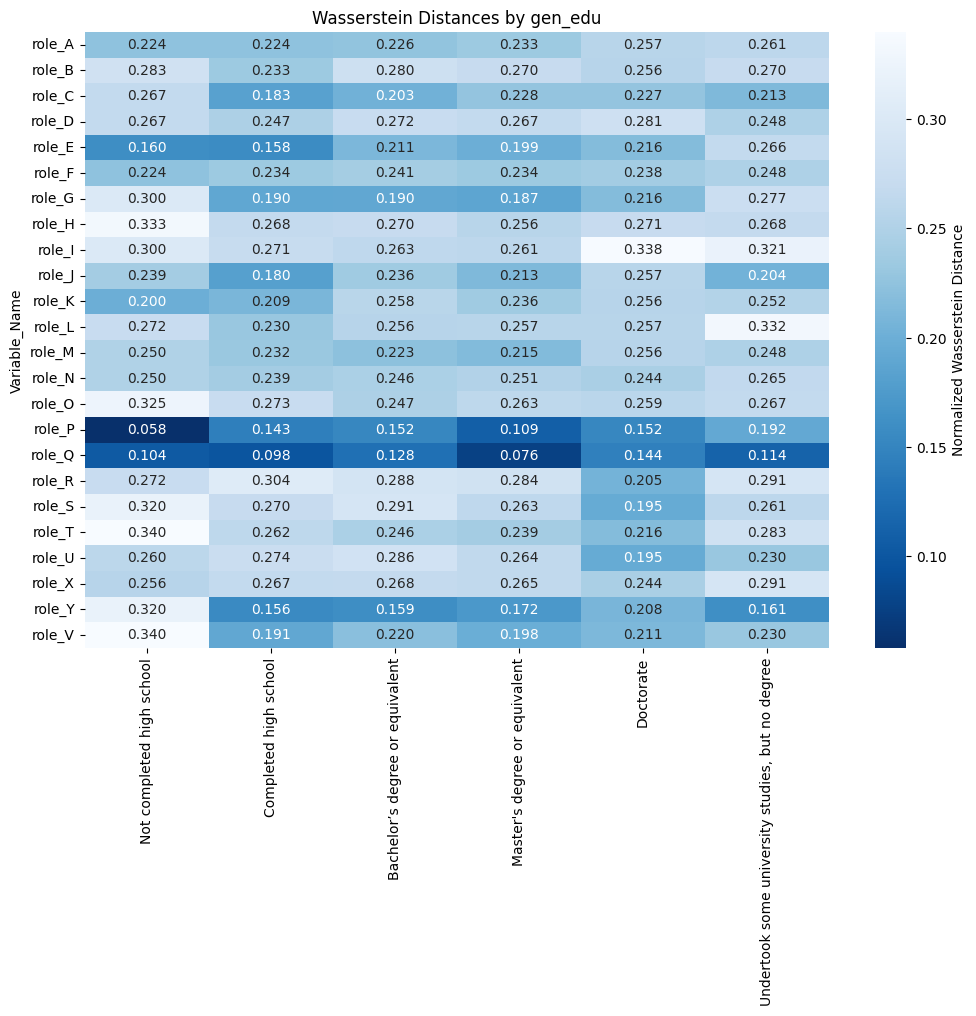

In [ ]:
# Function to compute Wasserstein distance between GPT response and human distribution
def compute_wasserstein_distance(human_distribution, gpt_response):
    options = human_distribution.index
    human_probs = human_distribution.values
    gpt_value = gpt_response

    # Create a distribution for GPT response
    gpt_probs = np.zeros_like(human_probs)
    if gpt_value in options:
        gpt_probs[options.get_loc(gpt_value)] = 1

    # Compute Wasserstein distance
    distance = wasserstein_distance(gpt_probs, human_probs)
    return distance

# Function to generate heatmap for a given grouping variable
def generate_heatmap(human_df, gpt_responses_df, variables, group_col, group_labels, group_name):
    # Initialize an empty list to store the results
    rows_list = []

    # Loop through each variable to compute distances
    for var in variables:
        response_row = gpt_responses_df.loc[gpt_responses_df['Variable_Name'] == var, 'Response']

        if response_row.empty:
            print(f"No response found for variable: {var}")
            continue  # Skip this variable if no response is found

        gpt_response = int(response_row.values[0])

        # Compute Wasserstein distances for each group in the grouping variable
        distances = {}
        for group in group_labels.keys():
            human_distribution = human_df[human_df[group_col] == group][var].value_counts(normalize=True).sort_index()

            if human_distribution.empty:
                print(f"No data for group: {group_labels[group]} and variable: {var}")
                distances[group_labels[group]] = np.nan  # or some default value like 0
                continue

            distances[group_labels[group]] = compute_wasserstein_distance(human_distribution, gpt_response)

        # Prepare a dictionary for the new row and append it to the list
        row = {
            'Variable_Name': var,
            **distances
        }
        rows_list.append(row)

    # Convert the list of rows into a DataFrame
    results_df = pd.DataFrame(rows_list)

    # Set the 'Variable_Name' as the index for the table
    results_df.set_index('Variable_Name', inplace=True)

    # Create a heatmap with darker colors for smaller values
    plt.figure(figsize=(12, 8))
    sns.heatmap(results_df, cmap='Blues_r', annot=True, fmt=".3f", cbar_kws={'label': 'Normalized Wasserstein Distance'})
    plt.title(f'Wasserstein Distances by {group_name}')
    plt.show()

# List of variables to process
variables = ["role_A", "role_B", "role_C", "role_D", "role_E", "role_F", "role_G", "role_H",
             "role_I", "role_J", "role_K", "role_L", "role_M", "role_N", "role_O", "role_P",
             "role_Q", "role_R", "role_S", "role_T", "role_U", "role_X", "role_Y", "role_V"]

# Define labels for each grouping variable
grouping_variables = {
    'pol_view_group': {'left': 'Left', 'center': 'Center', 'right': 'Right'},
    'gender': {1: 'Female', 2: 'Male', 3: 'Other'},
    'empl': {
        1: 'Full-time permanent contract',
        2: 'Part-time permanent contract',
        3: 'Full-time fixed-term contract',
        4: 'Part-time fixed-term contract',
        5: 'Freelance or self-employed'
    },
    'mbackg': {
        1: 'Newspaper', 2: 'Magazine', 3: 'TV', 4: 'Radio',
        5: 'News agency', 6: 'Internet native', 7: 'Telecommunications',
        8: 'Other', 9: 'No main medium'
    },
    'gen_edu': {
        1: 'Not completed high school',
        2: 'Completed high school',
        3: 'Bachelor’s degree or equivalent',
        4: 'Master\'s degree or equivalent',
        5: 'Doctorate',
        6: 'Undertook some university studies, but no degree'
    }
}

# Generate heatmaps for each grouping variable
for group_col, group_labels in grouping_variables.items():
    generate_heatmap(human_df, gpt_responses_df, variables, group_col, group_labels, group_col)


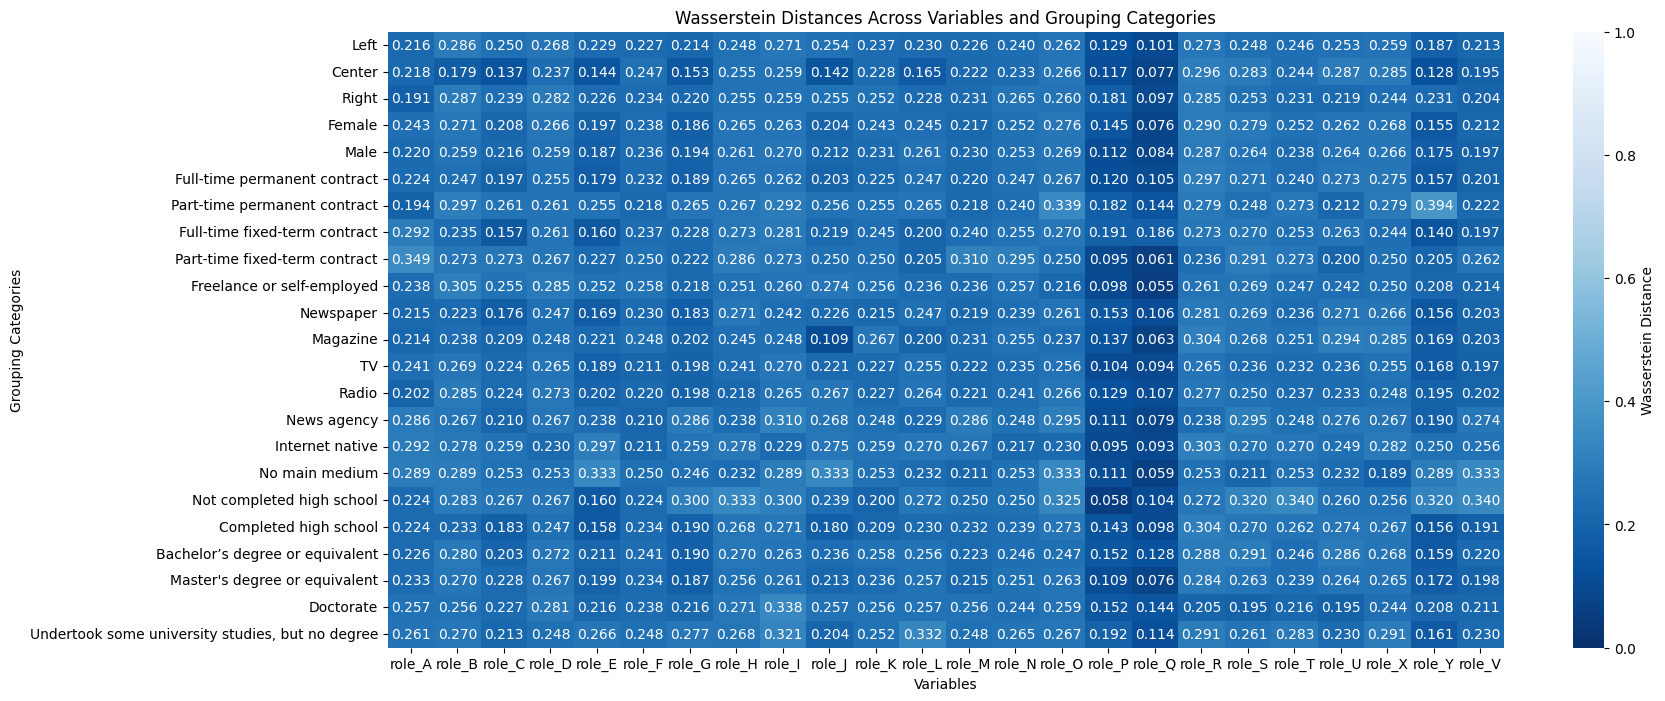

In [ ]:
# Function to compute Wasserstein distance between GPT response and human distribution
def compute_wasserstein_distance(human_distribution, gpt_response):
    options = human_distribution.index
    human_probs = human_distribution.values
    gpt_value = gpt_response

    # Create a distribution for GPT response
    gpt_probs = np.zeros_like(human_probs)
    if gpt_value in options:
        gpt_probs[options.get_loc(gpt_value)] = 1

    # Check if the distribution is empty
    if len(human_probs) == 0 or len(gpt_probs) == 0:
        return np.nan

    # Compute Wasserstein distance
    distance = wasserstein_distance(gpt_probs, human_probs)
    return distance

# Function to generate an integrated heatmap for all variables and grouping categories
def generate_integrated_heatmap(human_df, gpt_responses_df, variables, grouping_variables):
    # Initialize an empty DataFrame to store the results
    heatmap_data = pd.DataFrame(columns=variables)

    # Compute Wasserstein distances for each group and variable
    for group_col, group_labels in grouping_variables.items():
        for group, label in group_labels.items():
            row = {}
            for var in variables:
                gpt_response = int(gpt_responses_df.loc[gpt_responses_df['Variable_Name'] == var, 'Response'].values[0])
                human_distribution = human_df[human_df[group_col] == group][var].value_counts(normalize=True).sort_index()

                # Check if the distribution is empty and skip if it is
                if not human_distribution.empty:
                    distance = compute_wasserstein_distance(human_distribution, gpt_response)
                    row[var] = distance
                else:
                    row[var] = np.nan

            # Add the row for this group
            heatmap_data.loc[label] = row

    # Create a heatmap with raw scores
    plt.figure(figsize=(18, 8))
    sns.heatmap(heatmap_data.astype(float), cmap='Blues_r', annot=True, fmt=".3f", vmin=0, vmax=1, cbar_kws={'label': 'Wasserstein Distance'})
    plt.title('Wasserstein Distances Across Variables and Grouping Categories', fontsize=12)  # Smaller title size
    plt.xlabel('Variables')
    plt.ylabel('Grouping Categories')
    plt.show()

# Example usage
variables = ["role_A", "role_B", "role_C", "role_D", "role_E", "role_F", "role_G", "role_H",
             "role_I", "role_J", "role_K", "role_L", "role_M", "role_N", "role_O", "role_P",
             "role_Q", "role_R", "role_S", "role_T", "role_U", "role_X", "role_Y", "role_V"]

grouping_variables = {
    'pol_view_group': {'left': 'Left', 'center': 'Center', 'right': 'Right'},
    'gender': {1: 'Female', 2: 'Male'},
    'empl': {
        1: 'Full-time permanent contract',
        2: 'Part-time permanent contract',
        3: 'Full-time fixed-term contract',
        4: 'Part-time fixed-term contract',
        5: 'Freelance or self-employed'
    },
    'mbackg': {
        1: 'Newspaper', 2: 'Magazine', 3: 'TV', 4: 'Radio',
        5: 'News agency', 6: 'Internet native',
        9: 'No main medium'
    },
    'gen_edu': {
        1: 'Not completed high school',
        2: 'Completed high school',
        3: 'Bachelor’s degree or equivalent',
        4: 'Master\'s degree or equivalent',
        5: 'Doctorate',
        6: 'Undertook some university studies, but no degree'
    }
}

# Generate an integrated heatmap for all variables and grouping categories
generate_integrated_heatmap(human_df, gpt_responses_df, variables, grouping_variables)



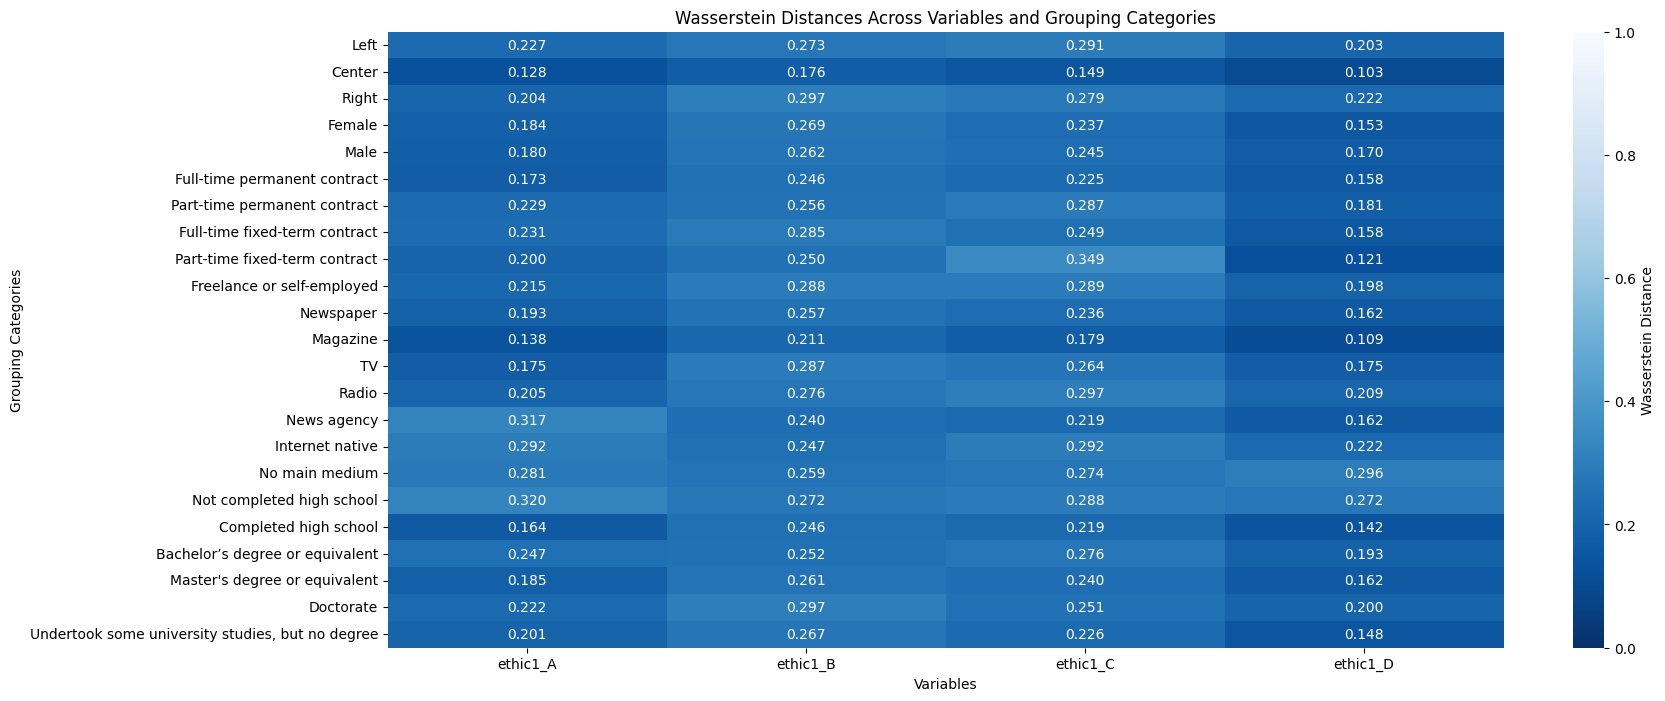

In [ ]:
# Function to compute Wasserstein distance between GPT response and human distribution
def compute_wasserstein_distance(human_distribution, gpt_response):
    options = human_distribution.index
    human_probs = human_distribution.values
    gpt_value = gpt_response

    # Create a distribution for GPT response
    gpt_probs = np.zeros_like(human_probs)
    if gpt_value in options:
        gpt_probs[options.get_loc(gpt_value)] = 1

    # Check if the distribution is empty
    if len(human_probs) == 0 or len(gpt_probs) == 0:
        return np.nan

    # Compute Wasserstein distance
    distance = wasserstein_distance(gpt_probs, human_probs)
    return distance

# Function to generate an integrated heatmap for all variables and grouping categories
def generate_integrated_heatmap(human_df, gpt_responses_df, variables, grouping_variables):
    # Initialize an empty DataFrame to store the results
    heatmap_data = pd.DataFrame(columns=variables)

    # Compute Wasserstein distances for each group and variable
    for group_col, group_labels in grouping_variables.items():
        for group, label in group_labels.items():
            row = {}
            for var in variables:
                gpt_response = int(gpt_responses_df.loc[gpt_responses_df['Variable_Name'] == var, 'Response'].values[0])
                human_distribution = human_df[human_df[group_col] == group][var].value_counts(normalize=True).sort_index()

                # Check if the distribution is empty and skip if it is
                if not human_distribution.empty:
                    distance = compute_wasserstein_distance(human_distribution, gpt_response)
                    row[var] = distance
                else:
                    row[var] = np.nan

            # Add the row for this group
            heatmap_data.loc[label] = row

    # Create a heatmap with raw scores
    plt.figure(figsize=(18, 8))
    sns.heatmap(heatmap_data.astype(float), cmap='Blues_r', annot=True, fmt=".3f", vmin=0, vmax=1, cbar_kws={'label': 'Wasserstein Distance'})
    plt.title('Wasserstein Distances Across Variables and Grouping Categories', fontsize=12)  # Smaller title size
    plt.xlabel('Variables')
    plt.ylabel('Grouping Categories')
    plt.show()

# Example usage
variables = ["ethic1_A", "ethic1_B", "ethic1_C", "ethic1_D"]

grouping_variables = {
    'pol_view_group': {'left': 'Left', 'center': 'Center', 'right': 'Right'},
    'gender': {1: 'Female', 2: 'Male'},
    'empl': {
        1: 'Full-time permanent contract',
        2: 'Part-time permanent contract',
        3: 'Full-time fixed-term contract',
        4: 'Part-time fixed-term contract',
        5: 'Freelance or self-employed'
    },
    'mbackg': {
        1: 'Newspaper', 2: 'Magazine', 3: 'TV', 4: 'Radio',
        5: 'News agency', 6: 'Internet native',
        9: 'No main medium'
    },
    'gen_edu': {
        1: 'Not completed high school',
        2: 'Completed high school',
        3: 'Bachelor’s degree or equivalent',
        4: 'Master\'s degree or equivalent',
        5: 'Doctorate',
        6: 'Undertook some university studies, but no degree'
    }
}

# Generate an integrated heatmap for all variables and grouping categories
generate_integrated_heatmap(human_df, gpt_responses_df, variables, grouping_variables)



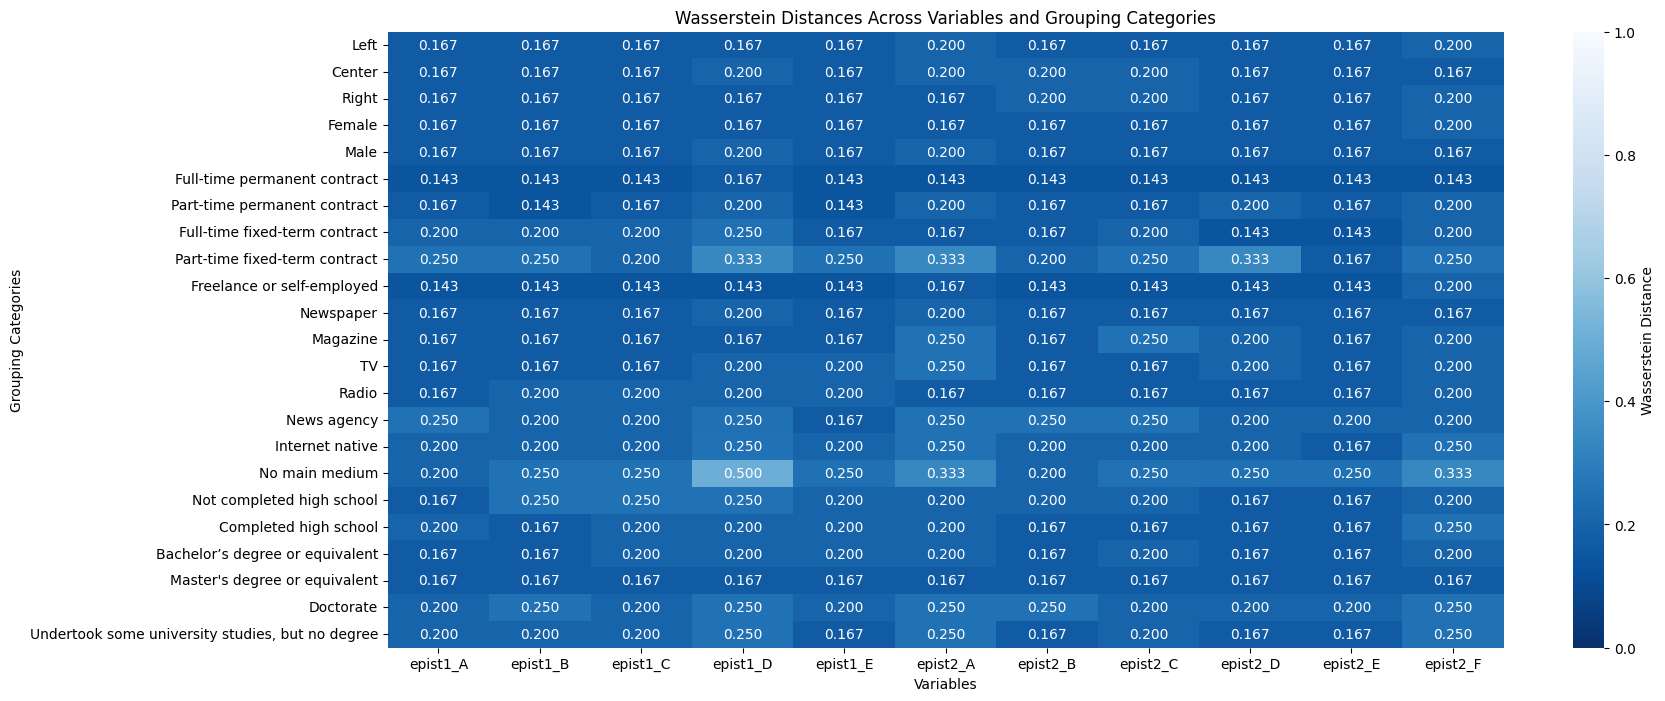

In [ ]:
# Function to compute Wasserstein distance between GPT response and human distribution
def compute_wasserstein_distance(human_distribution, gpt_response):
    options = human_distribution.index
    human_probs = human_distribution.values
    gpt_value = gpt_response

    # Create a distribution for GPT response
    gpt_probs = np.zeros_like(human_probs)
    if gpt_value in options:
        gpt_probs[options.get_loc(gpt_value)] = 1

    # Check if the distribution is empty
    if len(human_probs) == 0 or len(gpt_probs) == 0:
        return np.nan

    # Compute Wasserstein distance
    distance = wasserstein_distance(gpt_probs, human_probs)
    return distance

# Function to generate an integrated heatmap for all variables and grouping categories
def generate_integrated_heatmap(human_df, gpt_responses_df, variables, grouping_variables):
    # Initialize an empty DataFrame to store the results
    heatmap_data = pd.DataFrame(columns=variables)

    # Compute Wasserstein distances for each group and variable
    for group_col, group_labels in grouping_variables.items():
        for group, label in group_labels.items():
            row = {}
            for var in variables:
                gpt_response = int(gpt_responses_df.loc[gpt_responses_df['Variable_Name'] == var, 'Response'].values[0])
                human_distribution = human_df[human_df[group_col] == group][var].value_counts(normalize=True).sort_index()

                # Check if the distribution is empty and skip if it is
                if not human_distribution.empty:
                    distance = compute_wasserstein_distance(human_distribution, gpt_response)
                    row[var] = distance
                else:
                    row[var] = np.nan

            # Add the row for this group
            heatmap_data.loc[label] = row

    # Create a heatmap with raw scores
    plt.figure(figsize=(18, 8))
    sns.heatmap(heatmap_data.astype(float), cmap='Blues_r', annot=True, fmt=".3f", vmin=0, vmax=1, cbar_kws={'label': 'Wasserstein Distance'})
    plt.title('Wasserstein Distances Across Variables and Grouping Categories', fontsize=12)  # Smaller title size
    plt.xlabel('Variables')
    plt.ylabel('Grouping Categories')
    plt.show()

# Example usage
variables = ["epist1_A", "epist1_B", "epist1_C", "epist1_D", "epist1_E",
             "epist2_A", "epist2_B", "epist2_C","epist2_D", "epist2_E", "epist2_F"]

grouping_variables = {
    'pol_view_group': {'left': 'Left', 'center': 'Center', 'right': 'Right'},
    'gender': {1: 'Female', 2: 'Male'},
    'empl': {
        1: 'Full-time permanent contract',
        2: 'Part-time permanent contract',
        3: 'Full-time fixed-term contract',
        4: 'Part-time fixed-term contract',
        5: 'Freelance or self-employed'
    },
    'mbackg': {
        1: 'Newspaper', 2: 'Magazine', 3: 'TV', 4: 'Radio',
        5: 'News agency', 6: 'Internet native',
        9: 'No main medium'
    },
    'gen_edu': {
        1: 'Not completed high school',
        2: 'Completed high school',
        3: 'Bachelor’s degree or equivalent',
        4: 'Master\'s degree or equivalent',
        5: 'Doctorate',
        6: 'Undertook some university studies, but no degree'
    }
}

# Generate an integrated heatmap for all variables and grouping categories
generate_integrated_heatmap(human_df, gpt_responses_df, variables, grouping_variables)



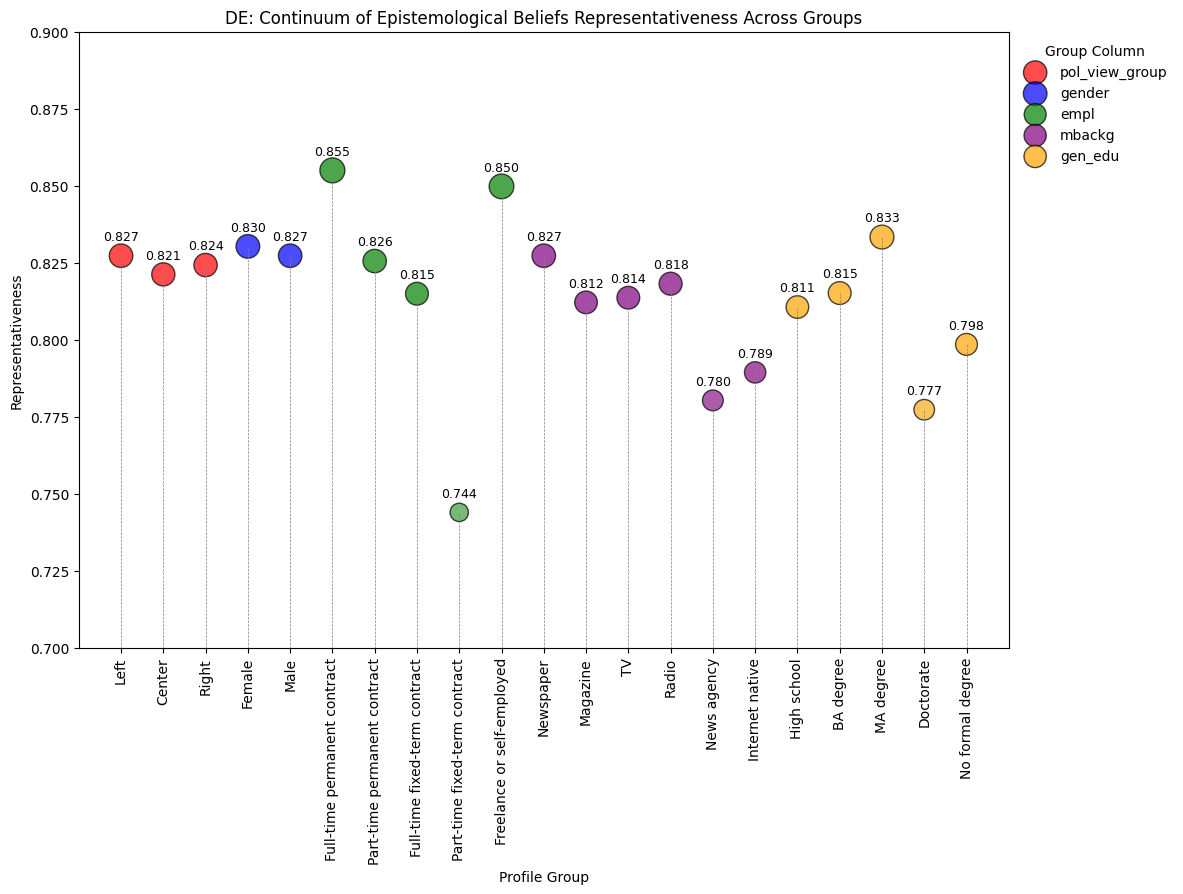

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize, to_hex
from matplotlib import cm, colors as mcolors

# Define a color palette for different groupings
color_palette = {
    'pol_view_group': 'red',
    'gender': 'blue',
    'empl': 'green',
    'mbackg': 'purple',
    'gen_edu': 'orange'
}

def create_colormap(base_color):
    # Create a colormap with more distinct contrast by using a wider range
    base_rgb = np.array(mcolors.to_rgb(base_color))
    light_color = np.clip(base_rgb + 0.65, 0.65, 0.8)  # Increase to 0.7 to lighten more
    return mcolors.LinearSegmentedColormap.from_list('custom_cmap', [to_hex(light_color), base_color])

# Function to compute representativeness for each group
def compute_representativeness(human_df, gpt_responses_df, variables, group_col, group_labels):
    rows_list = []

    for group in group_labels.keys():
        group_distances = []

        for var in variables:
            gpt_response = int(gpt_responses_df.loc[gpt_responses_df['Variable_Name'] == var, 'Response'].values[0])
            human_distribution = human_df[human_df[group_col] == group][var].value_counts(normalize=True).sort_index()

            if not human_distribution.empty:
                distance = compute_wasserstein_distance(human_distribution, gpt_response)
                group_distances.append(1 - distance)  # Representativeness is 1 - Wasserstein Distance
            else:
                group_distances.append(np.nan)

        if group_distances:
            avg_representativeness = np.nanmean(group_distances)
        else:
            avg_representativeness = np.nan  # Handle empty cases

        row = {
            'Group': group_labels[group],
            'Representativeness': avg_representativeness,
            'Group_Column': group_col
        }
        rows_list.append(row)

    results_df = pd.DataFrame(rows_list)
    return results_df

# Function to compute Wasserstein distance
def compute_wasserstein_distance(human_distribution, gpt_response):
    options = human_distribution.index
    human_probs = human_distribution.values
    gpt_value = gpt_response

    # Create a distribution for GPT response
    gpt_probs = np.zeros_like(human_probs)
    if gpt_value in options:
        gpt_probs[options.get_loc(gpt_value)] = 1

    # Check if the distribution is empty
    if len(human_probs) == 0 or len(gpt_probs) == 0:
        return np.nan

    # Compute Wasserstein distance
    distance = wasserstein_distance(gpt_probs, human_probs)
    return distance

# Function to generate the continuum plot
def generate_continuum_plot(human_df, gpt_responses_df, variables, grouping_variables):
    all_results = []

    for group_col, group_labels in grouping_variables.items():
        result = compute_representativeness(human_df, gpt_responses_df, variables, group_col, group_labels)
        all_results.append(result)

    combined_df = pd.concat(all_results, ignore_index=True)

    # Filter data to be within the 0.5 to 1.0 range
    combined_df = combined_df[(combined_df['Representativeness'] >= 0.5) & (combined_df['Representativeness'] <= 1.0)]

    # Plotting
    plt.figure(figsize=(12, 8))

    for group_col, base_color in color_palette.items():
        group_data = combined_df[combined_df['Group_Column'] == group_col]

        # Create and use the custom colormap for each base color
        cmap = create_colormap(base_color)
        norm = Normalize(vmin=0.65, vmax=0.8)

        # Compute colors based on representativeness (darker as representativeness increases)
        colors = [cmap(norm(val)) for val in group_data['Representativeness']]

        # Compute sizes based on representativeness
        sizes = 50 + 200 * norm(group_data['Representativeness'])  # Scale sizes

        scatter = plt.scatter(
            x=group_data['Group'],
            y=group_data['Representativeness'],
            c=colors,
            s=sizes,
            edgecolor='black',
            label=group_col,
            alpha=0.7
        )

    # Add text labels on the dots
    for i in range(combined_df.shape[0]):
        plt.text(
            x=combined_df['Group'].iloc[i],
            y=combined_df['Representativeness'].iloc[i] + 0.005,  # Adjust for better visibility
            s=f"{combined_df['Representativeness'].iloc[i]:.3f}",
            ha='center',
            fontsize=9
        )

    # Add lines connecting the x-axis labels to the dots
    for i in range(combined_df.shape[0]):
        plt.plot(
            [combined_df['Group'].iloc[i], combined_df['Group'].iloc[i]],  # x-coordinates: same value for start and end
            [0.5, combined_df['Representativeness'].iloc[i]],              # y-coordinates: from 0.5 to the dot's y-value
            color='gray', linestyle='--', linewidth=0.5
        )

    plt.axhline(0.5, color='red', linestyle='--')
    plt.ylim(0.70, 0.90)
    plt.xlabel('Profile Group')
    plt.ylabel('Representativeness')
    plt.title('DE: Continuum of Epistemological Beliefs Representativeness Across Groups')
    plt.xticks(rotation=90)  # Rotate x-axis labels vertically
    plt.legend(title='Group Column', loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

    plt.show()

# Example usage
variables = ["epist1_A", "epist1_B", "epist1_C", "epist1_D", "epist1_E",
             "epist2_A", "epist2_B", "epist2_C", "epist2_D", "epist2_E", "epist2_F"]

grouping_variables = {
    'pol_view_group': {'left': 'Left', 'center': 'Center', 'right': 'Right'},
    'gender': {1: 'Female', 2: 'Male'},
    'empl': {
        1: 'Full-time permanent contract',
        2: 'Part-time permanent contract',
        3: 'Full-time fixed-term contract',
        4: 'Part-time fixed-term contract',
        5: 'Freelance or self-employed'
    },
    'mbackg': {
        1: 'Newspaper', 2: 'Magazine', 3: 'TV', 4: 'Radio',
        5: 'News agency', 6: 'Internet native'
    },
    'gen_edu': {
        2: 'High school',
        3: 'BA degree',
        4: 'MA degree',
        5: 'Doctorate',
        6: 'No formal degree'
    }
}


# Generate the continuum line plot
generate_continuum_plot(human_df, gpt_responses_df, variables, grouping_variables)

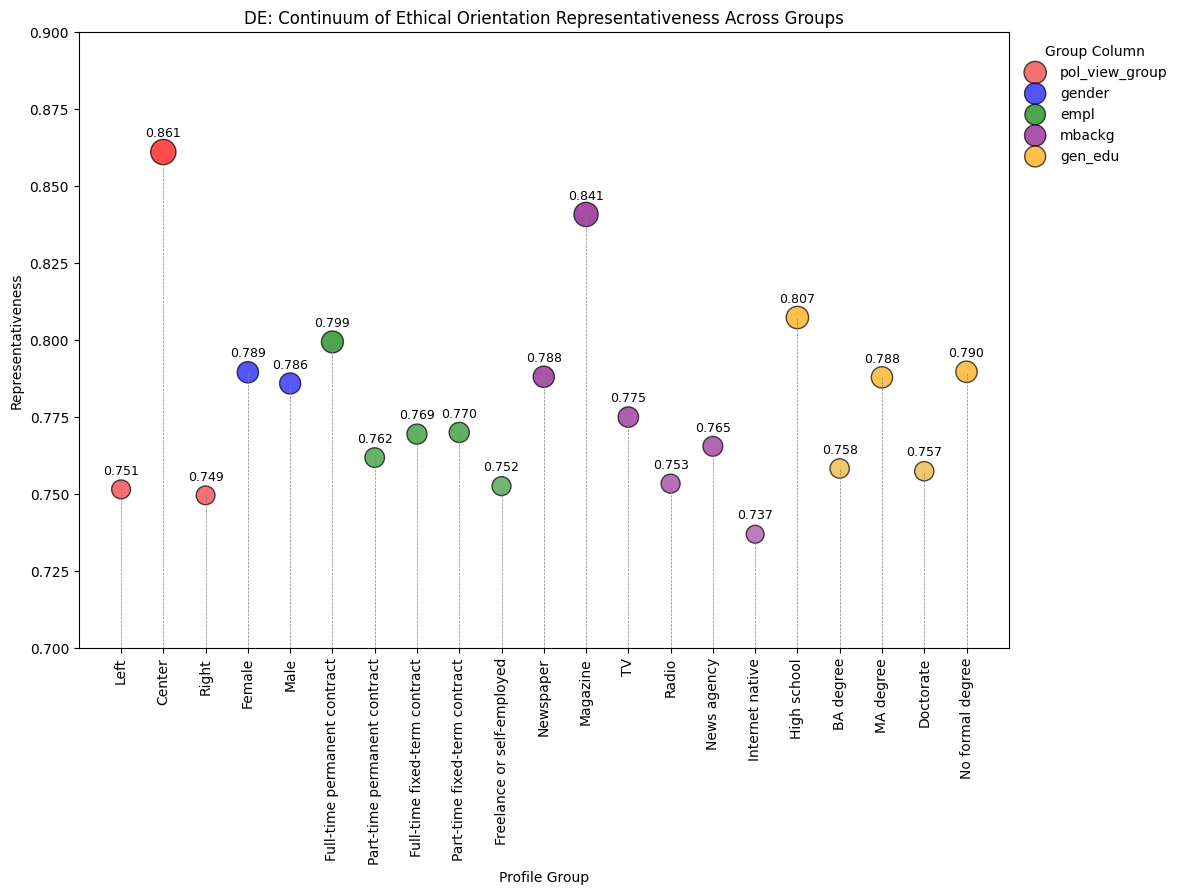

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize, to_hex
from matplotlib import cm, colors as mcolors

# Define a color palette for different groupings
color_palette = {
    'pol_view_group': 'red',
    'gender': 'blue',
    'empl': 'green',
    'mbackg': 'purple',
    'gen_edu': 'orange'
}

def create_colormap(base_color):
    # Create a colormap with more distinct contrast by using a wider range
    base_rgb = np.array(mcolors.to_rgb(base_color))
    light_color = np.clip(base_rgb + 0.65, 0.65, 0.8)  # Increase to 0.7 to lighten more
    return mcolors.LinearSegmentedColormap.from_list('custom_cmap', [to_hex(light_color), base_color])

# Function to compute representativeness for each group
def compute_representativeness(human_df, gpt_responses_df, variables, group_col, group_labels):
    rows_list = []

    for group in group_labels.keys():
        group_distances = []

        for var in variables:
            gpt_response = int(gpt_responses_df.loc[gpt_responses_df['Variable_Name'] == var, 'Response'].values[0])
            human_distribution = human_df[human_df[group_col] == group][var].value_counts(normalize=True).sort_index()

            if not human_distribution.empty:
                distance = compute_wasserstein_distance(human_distribution, gpt_response)
                group_distances.append(1 - distance)  # Representativeness is 1 - Wasserstein Distance
            else:
                group_distances.append(np.nan)

        if group_distances:
            avg_representativeness = np.nanmean(group_distances)
        else:
            avg_representativeness = np.nan  # Handle empty cases

        row = {
            'Group': group_labels[group],
            'Representativeness': avg_representativeness,
            'Group_Column': group_col
        }
        rows_list.append(row)

    results_df = pd.DataFrame(rows_list)
    return results_df

# Function to compute Wasserstein distance
def compute_wasserstein_distance(human_distribution, gpt_response):
    options = human_distribution.index
    human_probs = human_distribution.values
    gpt_value = gpt_response

    # Create a distribution for GPT response
    gpt_probs = np.zeros_like(human_probs)
    if gpt_value in options:
        gpt_probs[options.get_loc(gpt_value)] = 1

    # Check if the distribution is empty
    if len(human_probs) == 0 or len(gpt_probs) == 0:
        return np.nan

    # Compute Wasserstein distance
    distance = wasserstein_distance(gpt_probs, human_probs)
    return distance

# Function to generate the continuum plot
def generate_continuum_plot(human_df, gpt_responses_df, variables, grouping_variables):
    all_results = []

    for group_col, group_labels in grouping_variables.items():
        result = compute_representativeness(human_df, gpt_responses_df, variables, group_col, group_labels)
        all_results.append(result)

    combined_df = pd.concat(all_results, ignore_index=True)

    # Filter data to be within the 0.5 to 1.0 range
    combined_df = combined_df[(combined_df['Representativeness'] >= 0.5) & (combined_df['Representativeness'] <= 1.0)]

    # Plotting
    plt.figure(figsize=(12, 8))

    for group_col, base_color in color_palette.items():
        group_data = combined_df[combined_df['Group_Column'] == group_col]

        # Create and use the custom colormap for each base color
        cmap = create_colormap(base_color)
        norm = Normalize(vmin=0.65, vmax=0.8)

        # Compute colors based on representativeness (darker as representativeness increases)
        colors = [cmap(norm(val)) for val in group_data['Representativeness']]

        # Compute sizes based on representativeness
        sizes = 50 + 200 * norm(group_data['Representativeness'])  # Scale sizes

        scatter = plt.scatter(
            x=group_data['Group'],
            y=group_data['Representativeness'],
            c=colors,
            s=sizes,
            edgecolor='black',
            label=group_col,
            alpha=0.7
        )

    # Add text labels on the dots
    for i in range(combined_df.shape[0]):
        plt.text(
            x=combined_df['Group'].iloc[i],
            y=combined_df['Representativeness'].iloc[i] + 0.005,  # Adjust for better visibility
            s=f"{combined_df['Representativeness'].iloc[i]:.3f}",
            ha='center',
            fontsize=9
        )

    # Add lines connecting the x-axis labels to the dots
    for i in range(combined_df.shape[0]):
        plt.plot(
            [combined_df['Group'].iloc[i], combined_df['Group'].iloc[i]],  # x-coordinates: same value for start and end
            [0.5, combined_df['Representativeness'].iloc[i]],              # y-coordinates: from 0.5 to the dot's y-value
            color='gray', linestyle='--', linewidth=0.5
        )

    plt.axhline(0.5, color='red', linestyle='--')
    plt.ylim(0.70, 0.90)
    plt.xlabel('Profile Group')
    plt.ylabel('Representativeness')
    plt.title('DE: Continuum of Ethical Orientation Representativeness Across Groups')
    plt.xticks(rotation=90)  # Rotate x-axis labels vertically
    plt.legend(title='Group Column', loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

    plt.show()

# Example usage
variables = ["ethic1_A", "ethic1_B", "ethic1_C", "ethic1_D"]

grouping_variables = {
    'pol_view_group': {'left': 'Left', 'center': 'Center', 'right': 'Right'},
    'gender': {1: 'Female', 2: 'Male'},
    'empl': {
        1: 'Full-time permanent contract',
        2: 'Part-time permanent contract',
        3: 'Full-time fixed-term contract',
        4: 'Part-time fixed-term contract',
        5: 'Freelance or self-employed'
    },
    'mbackg': {
        1: 'Newspaper', 2: 'Magazine', 3: 'TV', 4: 'Radio',
        5: 'News agency', 6: 'Internet native'
    },
    'gen_edu': {
        2: 'High school',
        3: 'BA degree',
        4: 'MA degree',
        5: 'Doctorate',
        6: 'No formal degree'
    }
}


# Generate the continuum line plot
generate_continuum_plot(human_df, gpt_responses_df, variables, grouping_variables)


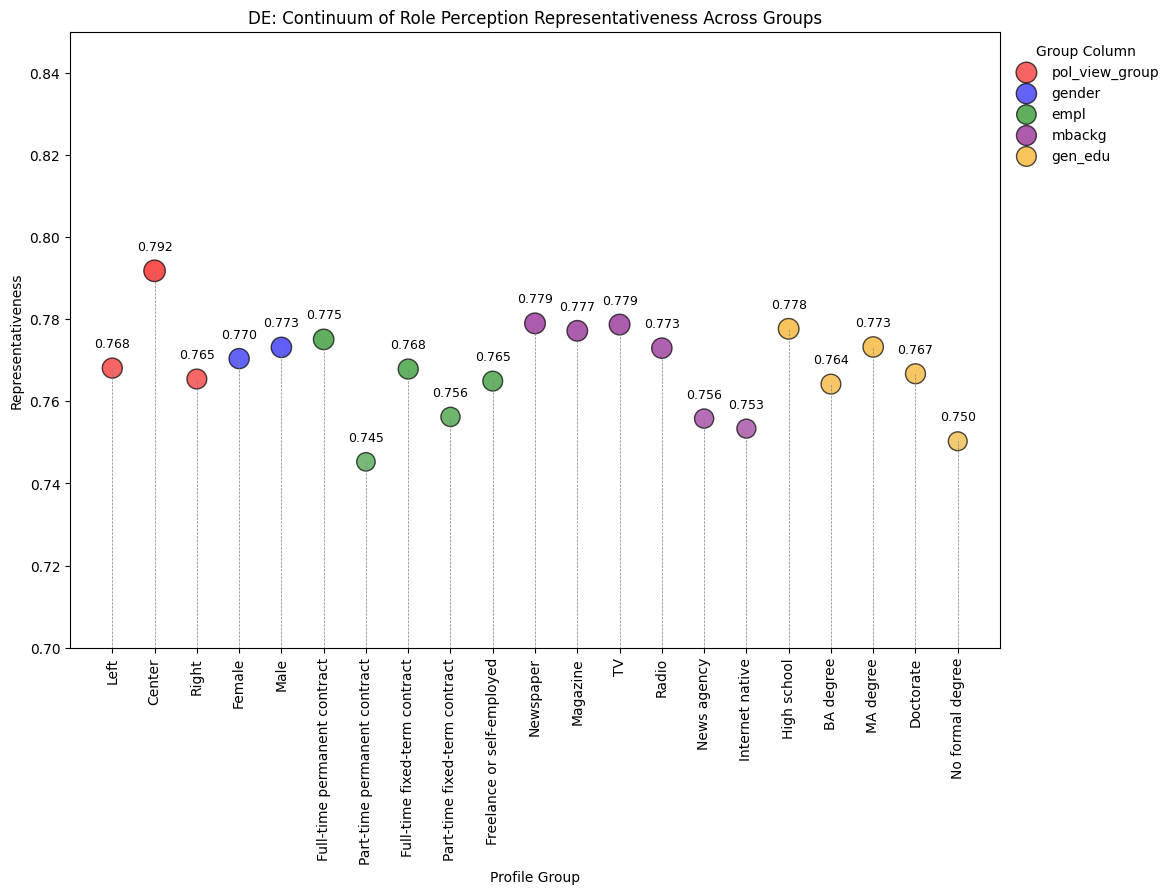

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize, to_hex
from matplotlib import cm, colors as mcolors

# Define a color palette for different groupings
color_palette = {
    'pol_view_group': 'red',
    'gender': 'blue',
    'empl': 'green',
    'mbackg': 'purple',
    'gen_edu': 'orange'
}

def create_colormap(base_color):
    # Create a colormap with more distinct contrast by using a wider range
    base_rgb = np.array(mcolors.to_rgb(base_color))
    light_color = np.clip(base_rgb + 0.65, 0.65, 0.8)  # Increase to 0.7 to lighten more
    return mcolors.LinearSegmentedColormap.from_list('custom_cmap', [to_hex(light_color), base_color])

# Function to compute representativeness for each group
def compute_representativeness(human_df, gpt_responses_df, variables, group_col, group_labels):
    rows_list = []

    for group in group_labels.keys():
        group_distances = []

        for var in variables:
            gpt_response = int(gpt_responses_df.loc[gpt_responses_df['Variable_Name'] == var, 'Response'].values[0])
            human_distribution = human_df[human_df[group_col] == group][var].value_counts(normalize=True).sort_index()

            if not human_distribution.empty:
                distance = compute_wasserstein_distance(human_distribution, gpt_response)
                group_distances.append(1 - distance)  # Representativeness is 1 - Wasserstein Distance
            else:
                group_distances.append(np.nan)

        if group_distances:
            avg_representativeness = np.nanmean(group_distances)
        else:
            avg_representativeness = np.nan  # Handle empty cases

        row = {
            'Group': group_labels[group],
            'Representativeness': avg_representativeness,
            'Group_Column': group_col
        }
        rows_list.append(row)

    results_df = pd.DataFrame(rows_list)
    return results_df

# Function to compute Wasserstein distance
def compute_wasserstein_distance(human_distribution, gpt_response):
    options = human_distribution.index
    human_probs = human_distribution.values
    gpt_value = gpt_response

    # Create a distribution for GPT response
    gpt_probs = np.zeros_like(human_probs)
    if gpt_value in options:
        gpt_probs[options.get_loc(gpt_value)] = 1

    # Check if the distribution is empty
    if len(human_probs) == 0 or len(gpt_probs) == 0:
        return np.nan

    # Compute Wasserstein distance
    distance = wasserstein_distance(gpt_probs, human_probs)
    return distance

# Function to generate the continuum plot
def generate_continuum_plot(human_df, gpt_responses_df, variables, grouping_variables):
    all_results = []

    for group_col, group_labels in grouping_variables.items():
        result = compute_representativeness(human_df, gpt_responses_df, variables, group_col, group_labels)
        all_results.append(result)

    combined_df = pd.concat(all_results, ignore_index=True)

    # Filter data to be within the 0.5 to 1.0 range
    combined_df = combined_df[(combined_df['Representativeness'] >= 0.5) & (combined_df['Representativeness'] <= 1.0)]

    # Plotting
    plt.figure(figsize=(12, 8))

    for group_col, base_color in color_palette.items():
        group_data = combined_df[combined_df['Group_Column'] == group_col]

        # Create and use the custom colormap for each base color
        cmap = create_colormap(base_color)
        norm = Normalize(vmin=0.65, vmax=0.8)

        # Compute colors based on representativeness (darker as representativeness increases)
        colors = [cmap(norm(val)) for val in group_data['Representativeness']]

        # Compute sizes based on representativeness
        sizes = 50 + 200 * norm(group_data['Representativeness'])  # Scale sizes

        scatter = plt.scatter(
            x=group_data['Group'],
            y=group_data['Representativeness'],
            c=colors,
            s=sizes,
            edgecolor='black',
            label=group_col,
            alpha=0.7
        )

    # Add text labels on the dots
    for i in range(combined_df.shape[0]):
        plt.text(
            x=combined_df['Group'].iloc[i],
            y=combined_df['Representativeness'].iloc[i] + 0.005,  # Adjust for better visibility
            s=f"{combined_df['Representativeness'].iloc[i]:.3f}",
            ha='center',
            fontsize=9
        )

    # Add lines connecting the x-axis labels to the dots
    for i in range(combined_df.shape[0]):
        plt.plot(
            [combined_df['Group'].iloc[i], combined_df['Group'].iloc[i]],  # x-coordinates: same value for start and end
            [0.5, combined_df['Representativeness'].iloc[i]],              # y-coordinates: from 0.5 to the dot's y-value
            color='gray', linestyle='--', linewidth=0.5
        )

    plt.axhline(0.5, color='red', linestyle='--')
    plt.ylim(0.70, 0.85)
    plt.xlabel('Profile Group')
    plt.ylabel('Representativeness')
    plt.title('DE: Continuum of Role Perception Representativeness Across Groups')
    plt.xticks(rotation=90)  # Rotate x-axis labels vertically
    plt.legend(title='Group Column', loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

    plt.show()

# Example usage
variables = ["role_A", "role_B", "role_C", "role_D", "role_E", "role_F", "role_G", "role_H",
             "role_I", "role_J", "role_K", "role_L", "role_M", "role_N", "role_O", "role_P",
             "role_Q", "role_R", "role_S", "role_T", "role_U", "role_X", "role_Y", "role_V"]

grouping_variables = {
    'pol_view_group': {'left': 'Left', 'center': 'Center', 'right': 'Right'},
    'gender': {1: 'Female', 2: 'Male'},
    'empl': {
        1: 'Full-time permanent contract',
        2: 'Part-time permanent contract',
        3: 'Full-time fixed-term contract',
        4: 'Part-time fixed-term contract',
        5: 'Freelance or self-employed'
    },
    'mbackg': {
        1: 'Newspaper', 2: 'Magazine', 3: 'TV', 4: 'Radio',
        5: 'News agency', 6: 'Internet native'
    },
    'gen_edu': {
        2: 'High school',
        3: 'BA degree',
        4: 'MA degree',
        5: 'Doctorate',
        6: 'No formal degree'
    }
}

# Generate the continuum line plot
generate_continuum_plot(human_df, gpt_responses_df, variables, grouping_variables)


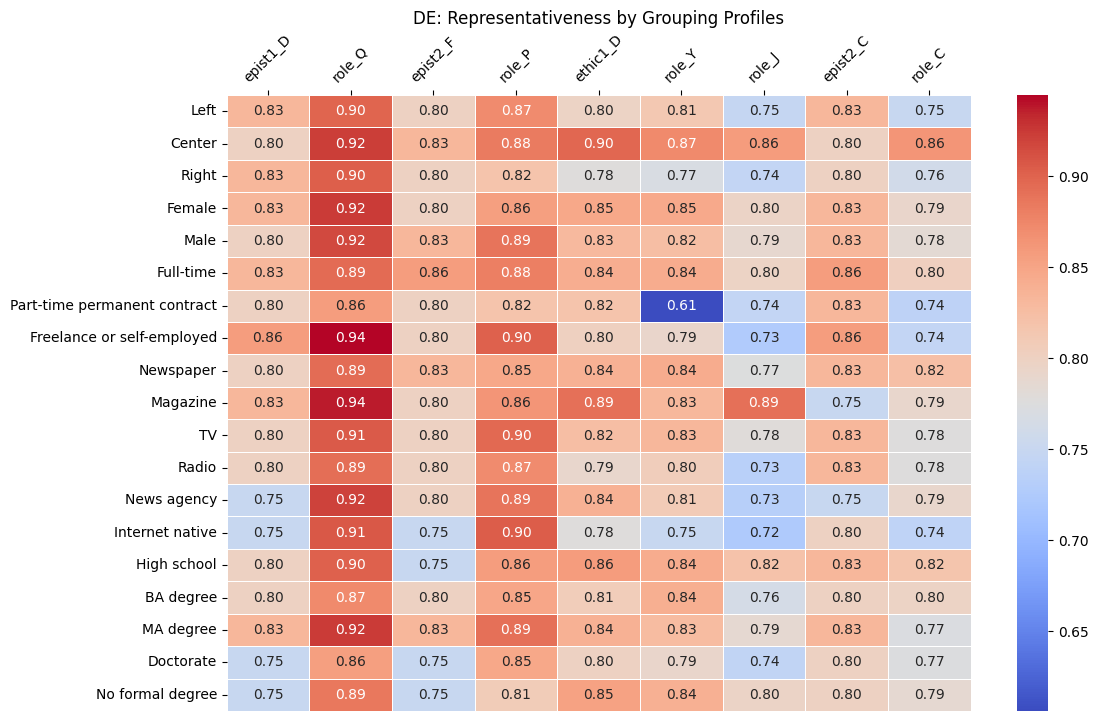

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Function to compute representativeness for each group
def compute_representativeness(human_df, gpt_responses_df, variables, group_col, group_labels):
    rows_list = []

    for group in group_labels.keys():
        group_distances = []

        for var in variables:
            gpt_response = int(gpt_responses_df.loc[gpt_responses_df['Variable_Name'] == var, 'Response'].values[0])
            human_distribution = human_df[human_df[group_col] == group][var].value_counts(normalize=True).sort_index()

            if not human_distribution.empty:
                distance = compute_wasserstein_distance(human_distribution, gpt_response)
                group_distances.append(1 - distance)  # Representativeness is 1 - Wasserstein Distance
            else:
                group_distances.append(np.nan)

        rows_list.append(group_distances)

    results_df = pd.DataFrame(rows_list, index=group_labels.values(), columns=variables)
    return results_df

# Function to compute Wasserstein distance
def compute_wasserstein_distance(human_distribution, gpt_response):
    options = human_distribution.index
    human_probs = human_distribution.values
    gpt_value = gpt_response

    # Create a distribution for GPT response
    gpt_probs = np.zeros_like(human_probs)
    if gpt_value in options:
        gpt_probs[options.get_loc(gpt_value)] = 1

    # Check if the distribution is empty
    if len(human_probs) == 0 or len(gpt_probs) == 0:
        return np.nan

    # Compute Wasserstein distance
    distance = wasserstein_distance(gpt_probs, human_probs)
    return distance

# Function to generate the heatmap
def generate_heatmap(human_df, gpt_responses_df, variables, grouping_variables):
    all_heatmaps = []

    for group_col, group_labels in grouping_variables.items():
        heatmap_data = compute_representativeness(human_df, gpt_responses_df, variables, group_col, group_labels)
        all_heatmaps.append(heatmap_data)

    # Combine heatmaps
    combined_heatmap_data = pd.concat(all_heatmaps)

    # Generate heatmap
    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(combined_heatmap_data, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)

    # Move the x-axis labels to the top
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')  # Also move the x-axis label to the top

    plt.xticks(rotation=45)
    plt.title('DE: Representativeness by Grouping Profiles')
    plt.show()

# Example usage
variables = ["epist1_D", "role_Q", "epist2_F", "role_P", "ethic1_D", "role_Y",
             "role_J", "epist2_C", "role_C"]

grouping_variables = {
    'pol_view_group': {'left': 'Left', 'center': 'Center', 'right': 'Right'},
    'gender': {1: 'Female', 2: 'Male'},
    'empl': {
        1: 'Full-time',
        2: 'Part-time permanent contract',
        5: 'Freelance or self-employed'
    },
    'mbackg': {
        1: 'Newspaper', 2: 'Magazine', 3: 'TV', 4: 'Radio',
        5: 'News agency', 6: 'Internet native'
    },
    'gen_edu': {
        2: 'High school',
        3: 'BA degree',
        4: 'MA degree',
        5: 'Doctorate',
        6: 'No formal degree'
    }
}

# Generate the heatmap
generate_heatmap(human_df, gpt_responses_df, variables, grouping_variables)